### 1. 패키지 설치 및 불러오기

In [1]:
# 패키지 설치: yfinance, Riskfolio-Lib
!pip install yfinance Riskfolio-Lib
!pip install --upgrade pandas

  Obtaining dependency information for Riskfolio-Lib from https://files.pythonhosted.org/packages/2c/96/269bcdec370ff4b4c65f8b67517a51b74a7bdd6c5f75367bcd87b0dc2fae/Riskfolio_Lib-6.0.0-cp311-cp311-macosx_10_9_universal2.whl.metadata
  Obtaining dependency information for clarabel>=0.6.0 from https://files.pythonhosted.org/packages/30/e0/6fd507d8e6be78a1ded2c076f10c30016c137e6a5eed46336de9875d1708/clarabel-0.7.1-cp37-abi3-macosx_10_12_x86_64.macosx_11_0_arm64.macosx_10_12_universal2.whl.metadata
  Obtaining dependency information for cvxpy>=1.4.0 from https://files.pythonhosted.org/packages/d8/06/39c63b6323a57d483f59b437a70d3cdac734d7c4ab21bca30f925dc4e3b0/cvxpy-1.4.3-cp311-cp311-macosx_10_9_universal2.whl.metadata
  Obtaining dependency information for xlsxwriter>=3.1.2 from https://files.pythonhosted.org/packages/a7/ea/53d1fe468e63e092cf16e2c18d16f50c29851242f9dd12d6a66e0d7f0d02/XlsxWriter-3.2.0-py3-none-any.whl.metadata
  Obtaining dependency information for pybind11>=2.10.1 from htt

In [13]:
# 패키지 임포트: numpy, pandas, matplotlib, seaborn, scipy, yfinance, sklearn, riskfolio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import yfinance as yf
import sklearn
import riskfolio as rp

#### 참고자료
- LedoitWolf: https://www.quantrocket.com/code/?repo=quant-finance-lectures&path=%2Fcodeload%2Fquant-finance-lectures%2Fquant_finance_lectures%2FLecture26-Estimating-Covariance-Matrices.ipynb.html
- Riskfolio-Lib: https://riskfolio-lib.readthedocs.io/en/latest/


### 2. ETF 데이터 수집 및 수익률 데이터 생성

- 티커 리스트

['SPY', 'FEZ', 'EWJ', 'EEM', 'IEF', 'TLT', 'TIP', 'GLD', 'DBC', 'DBA', 'IYR']

- 가격 데이터 시작일: 2007년 5월 1일
- 가격 데이터 종료일: 2023년 10월 31일
- 주간 단위로 리샘플링 및 종가 기준으로 백테스팅 수행

In [3]:
# ETF 가격 데이터 호출 함수
# 주간 단위로 리샘플링 및 종가 기준으로 백테스팅 수행
def get_price(tickers, start, end):
    data = yf.download(tickers, start=start, end=end)
    prices = data['Adj Close'].resample('W').last()
    return prices



In [7]:
# 가격 데이터
tickers = ['SPY', 'FEZ', 'EWJ', 'EEM', 'IEF', 'TLT', 'TIP', 'GLD', 'DBC', 'DBA', 'IYR']
start = '2007-05-01'
end = '2023-10-31'
prices = get_price(tickers, start=start, end=end)
prices.head()

# 주간 수익률 데이터
returns = prices.pct_change()[1:]
returns.head()

[*********************100%%**********************]  11 of 11 completed


Ticker,DBA,DBC,EEM,EWJ,FEZ,GLD,IEF,IYR,SPY,TIP,TLT
Date,,,,,,,,,,,
2007-05-13,-0.010933,-0.005492,0.009781,0.007623,-0.006416,-0.025517,-0.001930,0.007005,-0.000397,-0.002283,-0.004628
2007-05-20,-0.017765,0.003156,0.007146,-0.019945,0.015728,-0.013995,-0.007727,-0.058435,0.011666,-0.008259,-0.014287
2007-05-27,0.045016,0.006685,-0.008672,0.002105,-0.004890,-0.008852,-0.003164,0.000246,-0.006094,0.001104,-0.006442
2007-06-03,0.015000,0.003906,0.034831,0.028011,0.017854,0.023098,-0.005766,0.053551,0.015756,-0.004855,-0.005138
2007-06-10,0.001516,-0.008171,-0.030969,-0.001363,-0.031219,-0.033414,-0.009246,-0.032017,-0.019730,-0.007082,-0.020914


### 3. Shrinkage 방법론을 활용한 공분산 행렬 노이즈 제거

In [8]:
# Shrinkage 방법을 적용한 공분산 행렬 생성 함수
from sklearn import covariance
def get_cov_matrix(returns):
    # from sklearn import covariance 모듈의 ledoit_wolf를 활용한 공분산 행렬 노이즈 제거
    lw = covariance.ledoit_wolf(returns)[0]
    # lw 공분산 행렬 반환
    return lw

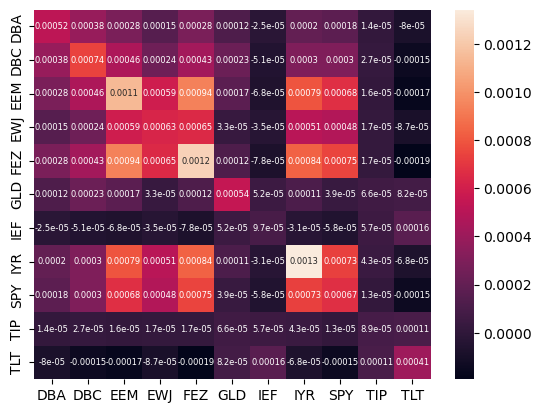

In [12]:
# 수축된 공분산 행렬
get_cov_matrix(returns)
# 수축된 공분산 행렬 히트맵(sns.heatmap) 시각화 (annot=True, annot_kws={"size": 8})
heatmap = sns.heatmap(get_cov_matrix(returns), annot=True, annot_kws={"size": 6}, xticklabels=returns.columns, yticklabels=returns.columns)

### 4. 계층적 리스크 패리티 포트폴리오

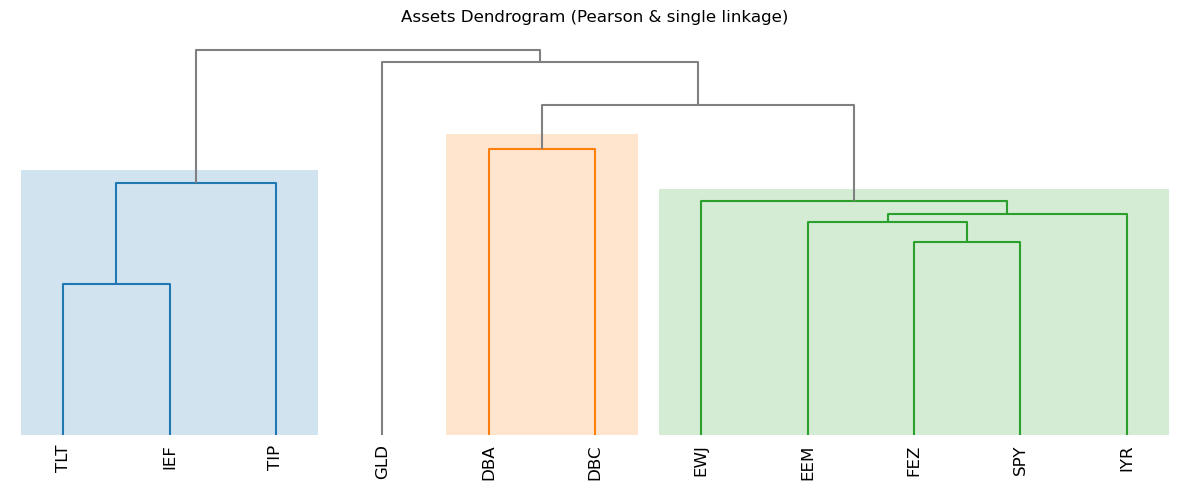

In [14]:
# 덴드로그램 구현
ax = rp.plot_dendrogram(returns=returns,
                        codependence='pearson',
                        linkage='single',
                        k=None,
                        max_k=10,
                        leaf_order=True,
                        ax=None)

In [16]:
# HRP 객체 구현
port = rp.HCPortfolio(returns=returns)

# HRP 가중치 계산
model = 'HRP'
codependence = 'pearson'# Correlation matrix used to group assets in clusters
rm = 'MV' # Risk measure used, this time will be variance
rf = 0 # Risk free rate
linkage = 'single' # Linkage method used to build clusters
max_k = 10 # Max number of clusters used in two difference gap statistic, only for HERC model
leaf_order = True # Consider optimal order of leafs in dendrogram

w = port.optimization(model=model,
                      codependence=codependence,
                      rm=rm,
                      rf=rf,
                      linkage=linkage,
                      max_k=max_k,
                      leaf_order=leaf_order)
display(w.T)

,DBA,DBC,EEM,EWJ,FEZ,GLD,IEF,IYR,SPY,TIP,TLT
weights,0.052443,0.032917,0.012679,0.023148,0.017037,0.050218,0.288904,0.009037,0.01818,0.434097,0.061342


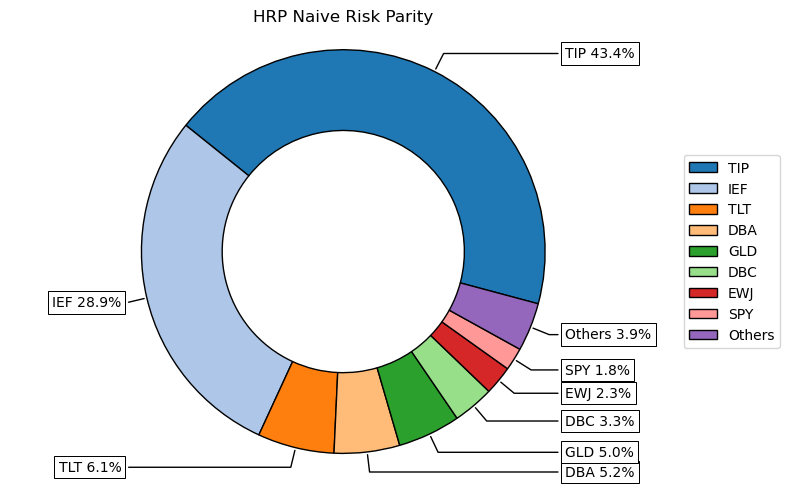

In [18]:
# 가중치 파이 차트 시각화
# Plotting the composition of the portfolio
ax = rp.plot_pie(w=w,
                 title='HRP Naive Risk Parity',
                 others=0.05,
                 nrow=25,
                 cmap="tab20",
                 height=5,
                 width=8,
                 ax=None)

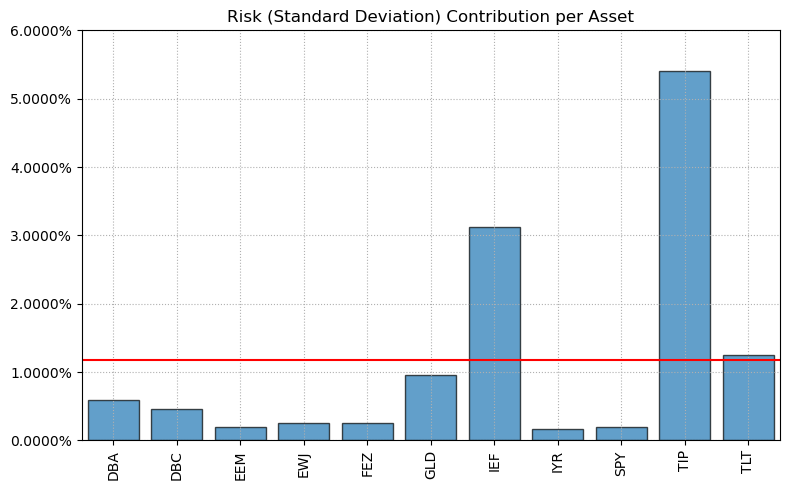

In [22]:
# 자산별 위험 기여도 계산 및 시각화
# Plotting the risk contribution per asset
mu = returns.mean()
cov = returns.cov() # Covariance matrix

ax = rp.plot_risk_con(w=w,
                      cov=cov,
                      returns=returns,
                      rm=rm,
                      rf=0,
                      alpha=0.05,
                      color="tab:blue",
                      height=5,
                      width=8,
                      t_factor=252,
                      ax=None)

#### 5. SRP, HRP 포트폴리오 백테스팅 엔진 클래스 구현

In [103]:
from scipy.optimize import minimize
# 포트폴리오 백테스팅 엔진 클래스
class BacktestEngine:
    # 초기화 함수
    def __init__(self, price, param=52):
        # 연율화 패러미터
        self.param = param
        # 주간 수익률
        self.rets = price.resample('W').last().pct_change()[1:]

    # 횡적 배분 모델 클래스
    class CrossSectional:
        # 축소 리스크 패리티 함수 (srp)
        def srp(self, returns):
            # 축소된 공분산 행렬 함수
            def get_cov_matrix(returns):
                lw = covariance.ledoit_wolf(returns)[0]
                return lw

            def risk_parity_objective(weights, cov_matrix):
                # Calculate portfolio variance
                portfolio_variance = weights.T @ cov_matrix @ weights
                # Marginal contribution to risk for each asset
                marginal_risk = cov_matrix @ weights
                # Risk contribution for each asset
                risk_contributions = np.multiply(weights, marginal_risk)
                # Equal risk contribution (total risk divided by number of assets)
                target_risk = np.sum(risk_contributions) / len(weights)
                # Objective function: sum of squared deviations from target risk
                return np.sum((risk_contributions - target_risk) ** 2)

            # Initial weights (equal weighted)
            num_assets = returns.shape[1]
            initial_weights = np.repeat(1 / num_assets, num_assets)
            
            # Covariance matrix
            cov_matrix = get_cov_matrix(returns)
            
            # Constraints: weights sum to 1 and are non-negative
            constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Sum to 1
                           {'type': 'ineq', 'fun': lambda x: x})  # Non-negative weights
            
            # Bounds for weights
            bounds = tuple((0, 1) for asset in range(num_assets))
            
            # Minimize the risk parity objective
            result = minimize(risk_parity_objective, initial_weights, args=(cov_matrix,),
                              method='SLSQP', bounds=bounds, constraints=constraints)
            
            if not result.success:
                raise BaseException('Risk Parity optimization did not converge')

            # 계산된 가중치 반환
            return result.x

        # 계층적 리스크 패리티 함수 (hrp)
        def hrp(self, returns):
            # 포트폴리오 객체 생성t
            port = rp.HCPortfolio(returns=returns)
            # 최적 포트폴리오 가중치 추정
            w = port.optimization(model=model,
                                  codependence=codependence,
                                  rm=rm,
                                  rf=rf,
                                  linkage=linkage,
                                  max_k=max_k,
                                  leaf_order=leaf_order)
            # 계산된 가중치 반환
            # If w is a DataFrame and you expect a single row:
            if isinstance(w, pd.DataFrame):
                # Ensure it's a single row and flatten to 1D
                w = w.squeeze()  # This converts a single row DataFrame to a Series (1D)
            
            return w

    # 거래비용 함수
    def transaction_cost(self, weights_df, rets_df, cost=0.0005):
        # 이전 기의 투자 가중치
        prev_weights_df = (weights_df.shift(1).fillna(0) * (1 + rets_df.iloc[self.param-1:,:])) \
        .div((weights_df.shift(1).fillna(0) * (1 + rets_df.iloc[self.param-1:,:])).sum(axis=1), axis=0)

        # 거래비용 데이터프레임
        cost_df = abs(weights_df - prev_weights_df) * cost
        cost_df.fillna(0, inplace=True)

        return cost_df

    # 백테스팅 실행 함수
    def run(self, cs_model, cost):
        # 빈 딕셔너리
        backtest_dict = {}
        # 주간 수익률 데이터프레임
        rets = self.rets

        # 횡적 배분 모델 선택 및 실행 (for 문)
        for index in rets.index[self.param-1:]:  # Assuming self.param is the window size
            window_rets = self.rets.loc[:index][-self.param:]  # Select last 'param' rows up to the current index
            if cs_model == 'SRP':
                backtest_dict[index] = self.CrossSectional().srp(window_rets)
            elif cs_model == 'HRP':
                backtest_dict[index] = self.CrossSectional().hrp(window_rets)
                
        # 횡적 가중치 데이터프레임
        cs_weights = pd.DataFrame([x if isinstance(x, np.ndarray) else x.values for x in backtest_dict.values()], 
                                    index=backtest_dict.keys(), 
                                    columns=rets.columns)
        cs_weights.fillna(0, inplace=True)

        # 횡적 배분 모델 자산 수익률
        cs_rets = cs_weights.shift(1) * rets.iloc[self.param-1:,:]

        # 횡적 배분 모델 포트폴리오 수익률
        cs_port_rets = cs_rets.sum(axis=1)

        # 최종 포트폴리오 투자 가중치
        # (종적 배분 모형을 사용하지 않으므로 횡적 배분 모델과 같은)
        port_weights = cs_weights

        # 거래비용 데이터프레임
        cost = self.transaction_cost(port_weights, rets)

        # 최종 포트폴리오 자산별 수익률
        port_asset_rets = port_weights.shift() * rets - cost
        
        # 최종 포트폴리오 수익률
        port_rets = port_asset_rets.sum(axis=1)
        port_rets.index = pd.to_datetime(port_rets.index).strftime('%Y-%m-%d')

        return port_rets

### 6. 백테스팅 엔진 실행 및 성과분석

In [104]:
# 엔진 초기화 (입력: 주간 가격 데이터)
engine = BacktestEngine(prices)
# SRP 포트폴리오 백테스팅 실행
res_srp = engine.run(cs_model='SRP', cost=0.0005)
# HRP 포트폴리오 백테스팅 실행
res_hrp = engine.run(cs_model='HRP', cost=0.0005)


In [105]:
# SRP 포트폴리오 수익률 시리즈
srp_port_rets = res_srp
# HRP 포트폴리오 수익률 시리즈
hrp_port_rets = res_hrp

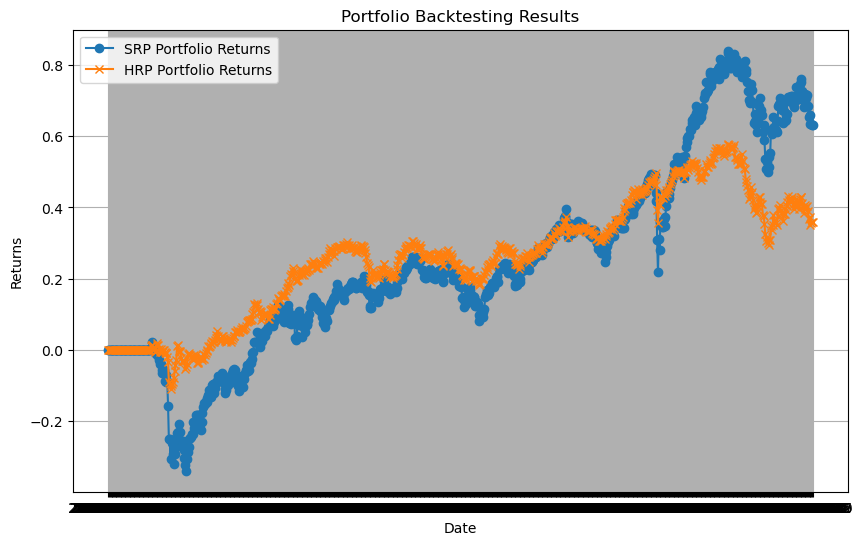

In [106]:
# SRP, HRP 포트폴리오 백테스팅 결과 시각화
plt.figure(figsize=(10, 6))
plt.plot((1+srp_port_rets).cumprod() - 1, label='SRP Portfolio Returns', marker='o')
plt.plot((1+hrp_port_rets).cumprod() - 1, label='HRP Portfolio Returns', marker='x')
plt.title('Portfolio Backtesting Results')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.grid(True)
plt.show()

In [107]:
# SRP 샤프비율 계산
sharpe_ratio_srp = srp_port_rets.mean() * np.sqrt(52) / srp_port_rets.std()
# HRP 사프비율 계산
sharpe_ratio_hrp = hrp_port_rets.mean() * np.sqrt(52) / hrp_port_rets.std()
# 두 포트폴리오의 샤프 비율 결과 출력
print('SRP Sharpe Ratio:', sharpe_ratio_srp)
print('HRP Sharpe Ratio:', sharpe_ratio_hrp)

SRP Sharpe Ratio: 0.32754963005063503
HRP Sharpe Ratio: 0.34269713958418996


Copyright 2023. 퀀트대디. All rights reserved.